In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import mel_processing
import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence
from  text.phonemeic import phoneme_to_sequence
from text.new import use_phoneme

from scipy.io.wavfile import write
from convertor import cmu_to_ipa


def get_text(text, hps):
    # text_norm = text_to_sequence(text, hps.data.text_cleaners)
    # clean_text = phoneme_to_sequence(text, hps.data.text_cleaners)
    # print(text_norm)  # ->list
    text_norm = use_phoneme(text)
    print(text_norm)
    # print(clean_text)  # plˈiːz kˈɔːl kˈɔːl stˈɛlə  str
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    print(text_norm)
    return text_norm

æ s k h ɚ t ə b r ɪ ŋ ð i z θ ɪ ŋ z w ɪ ð h ɚ f ɚ m ð ə s t ɔ r


In [3]:
from phonemizer import phonemize

text = "Please call Stella."
phonemes = phonemize(text, language='en-us', backend='espeak', strip=True, preserve_punctuation=True, with_stress=True)
print(phonemes)  # str

plˈiːz kˈɔːl stˈɛlə.


## LJ Speech

In [4]:
hps = utils.get_hparams_from_file("./configs/ljs_base.json")

In [5]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model)
_ = net_g.eval()
_ = utils.load_checkpoint("./saved_models/pretrained_vctk.pth", net_g, None)

INFO:root:Loaded checkpoint './saved_models/pretrained_vctk.pth' (iteration 0)


In [6]:
def get_audio_a(audio, sampling_rate):
    _sampling_rate = 22050
    _max_wav_value = 32768.0
    _filter_length = 1024
    _hop_length = 256
    _win_length = 1024

    # audio, sampling_rate = utils.load_wav_to_torch(filename)
    
    print(sampling_rate)
    if sampling_rate != _sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, _sampling_rate))
    
    print("audio shape: ", audio.shape)
        
    # Normalize the waveform between -1.0 and 1.0
    normalized_waveform = audio / torch.max(torch.abs(audio))

    # Scale the normalized waveform to the range of a 16-bit audio
    audio = normalized_waveform * 32767
    print(f"max auido norm before is {torch.max(audio)}")
    audio_norm = audio / _max_wav_value
    print(f"max auido norm is {torch.max(audio_norm)}")
    audio_norm = audio_norm.unsqueeze(0)
    # spec_filename = filename.replace(".wav", ".spec.pt")
    print("audio norm shape", audio_norm.shape)
    spec =  mel_processing.spectrogram_torch(audio_norm, _filter_length,
        _sampling_rate, _hop_length, _win_length,
        center=False)
    print(f"spec shape is {spec.shape}")
    spec = torch.squeeze(spec, 0)
    # torch.save(spec, spec_filename)
    return spec, audio_norm

In [7]:
def get_audio(path="../sample_data/raw_audio/p225_001.wav"):
    spec, wav = get_audio_a(path) #[spec is 1, d, t]

    return spec, wav 

In [8]:
def get_soft_attention(hps, net_g, text, text_lengths, spec, spec_lengths):
    with torch.no_grad():
        o, l_length, (neg_cent, attn), ids_slice, x_mask, y_mask, (z, z_p, m_p, logs_p, m_q, logs_q) = net_g(text, text_lengths, spec, spec_lengths)  # phoneme, mel_spec respectively
        neg_cent = neg_cent.squeeze(0)

        neg_cent = nn.functional.softmax(neg_cent, dim=1)

    return neg_cent

In [10]:
stn_tst = get_text("p..p..p..p pl'i:z k'ɔ:l st st st'ɛlə", hps)
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1.3)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

# spec, wav = 

# soft_attention = get_soft_attention(hps, net_g, x_tst, x_tst_lengths, )

[58, 4, 4, 58, 4, 4, 58, 4, 4, 58, 16, 58, 54, 176, 51, 2, 68, 16, 53, 176, 76, 2, 54, 16, 61, 62, 16, 61, 62, 16, 61, 62, 176, 86, 54, 83]
tensor([  0,  58,   0,   4,   0,   4,   0,  58,   0,   4,   0,   4,   0,  58,
          0,   4,   0,   4,   0,  58,   0,  16,   0,  58,   0,  54,   0, 176,
          0,  51,   0,   2,   0,  68,   0,  16,   0,  53,   0, 176,   0,  76,
          0,   2,   0,  54,   0,  16,   0,  61,   0,  62,   0,  16,   0,  61,
          0,  62,   0,  16,   0,  61,   0,  62,   0, 176,   0,  86,   0,  54,
          0,  83,   0])


## VCTK

In [12]:
hps = utils.get_hparams_from_file("./configs/vctk_base.json")

In [13]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model)
_ = net_g.eval()
_ = utils.load_checkpoint("./saved_models/pretrained_vctk.pth", net_g, None)

INFO:root:Loaded checkpoint './saved_models/pretrained_vctk.pth' (iteration 0)


In [30]:
stn_tst = get_text("p..p..p..plˈiːz kˈɔːl st..st..stˈɛlə.", hps)
print(stn_tst.shape)   # tensor

# ipa_sequence = cmu_to_ipa("P sp P sp P L IY1 Z K AO1 L S sp S sp S T EH1 L AH0")
# print(ipa_sequence)
# P sp P sp P L IY1 Z K AO1 L S sp S sp S T EH1 L AH0
# AE1 S K HH ER0 T AH0 B R IH1 NG DH IY1 Z TH IH1 NG Z W IH0 DH HH ER0 F ER0 M DH AH0 S T AO1 R
# stn_tst = get_text(ipa_sequence, hps)
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    sid = torch.LongTensor([51]) # set speaker-id
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, sid=sid,noise_scale_w=0.8, length_scale=1.6)[0][0,0].data.cpu().float().numpy()

print(audio)
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))



[58, 4, 4, 58, 4, 4, 58, 4, 4, 58, 54, 156, 51, 158, 68, 16, 53, 156, 76, 158, 54, 16, 61, 62, 4, 4, 61, 62, 4, 4, 61, 62, 156, 86, 54, 83, 4]
tensor([  0,  58,   0,   4,   0,   4,   0,  58,   0,   4,   0,   4,   0,  58,
          0,   4,   0,   4,   0,  58,   0,  54,   0, 156,   0,  51,   0, 158,
          0,  68,   0,  16,   0,  53,   0, 156,   0,  76,   0, 158,   0,  54,
          0,  16,   0,  61,   0,  62,   0,   4,   0,   4,   0,  61,   0,  62,
          0,   4,   0,   4,   0,  61,   0,  62,   0, 156,   0,  86,   0,  54,
          0,  83,   0,   4,   0])
torch.Size([75])
[-0.00235112 -0.00244974 -0.00256089 ...  0.00113478  0.00113846
  0.00092934]


In [15]:
def process_audio(spec, x_tst, x_tst_lengths):    
    y = spec.unsqueeze(0)
    y_lengths = torch.LongTensor([y.shape[-1]])
 
    o, l_length, (neg_cent, attn), ids_slice, x_mask, y_mask, (z, z_p, m_p, logs_p, m_q, logs_q) = net_g(x_tst, x_tst_lengths, y, y_lengths) #phoneme, mel_spec respectively

    print("neg_cent shape: ", neg_cent.shape)

    neg_cent = neg_cent.squeeze(0)

    neg_cent = nn.functional.softmax(neg_cent, dim=1)

    return neg_cent, attn

In [16]:
import numpy as np
spec, wav = get_audio_a(torch.FloatTensor(audio.astype(np.float32)), hps.data.sampling_rate)
neg_cent, attn = process_audio(spec, x_tst, x_tst_lengths)

22050
audio shape:  torch.Size([95744])
max auido norm before is 20537.357421875
max auido norm is 0.6267504096031189
audio norm shape torch.Size([1, 95744])
spec shape is torch.Size([1, 513, 374])
tensor([[  0,  58,   0,   4,   0,   4,   0,  58,   0,   4,   0,   4,   0,  58,
           0,   4,   0,   4,   0,  58,   0,  54,   0, 156,   0,  51,   0, 158,
           0,  68,   0,  16,   0,  53,   0, 156,   0,  76,   0, 158,   0,  54,
           0,  16,   0,  61,   0,  62,   0,   4,   0,   4,   0,  61,   0,  62,
           0,   4,   0,   4,   0,  61,   0,  62,   0, 156,   0,  86,   0,  54,
           0,  83,   0,   4,   0]]) tensor([75])
logs_p:  torch.Size([1, 192, 75])


/Users/steveli/anaconda3/envs/py39/lib/python3.9/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/aten/src/ATen/native/SpectralOps.cpp:867.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


torch.Size([1, 1, 75])
torch.Size([1, 374, 75])
torch.Size([1, 374, 75])
torch.Size([1, 1, 75])
neg_cent shape:  torch.Size([1, 374, 75])


tensor([[  0,  58,   0,   4,   0,   4,   0,  58,   0,   4,   0,   4,   0,  58,
           0,   4,   0,   4,   0,  58,   0,  54,   0, 156,   0,  51,   0, 158,
           0,  68,   0,  16,   0,  53,   0, 156,   0,  76,   0, 158,   0,  54,
           0,  16,   0,  61,   0,  62,   0,   4,   0,   4,   0,  61,   0,  62,
           0,   4,   0,   4,   0,  61,   0,  62,   0, 156,   0,  86,   0,  54,
           0,  83,   0,   4,   0]])
probability shape is torch.Size([374, 75])
prob shape:  torch.Size([374, 75])


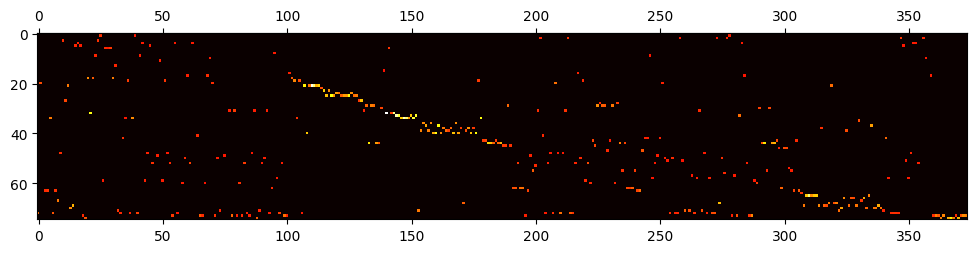

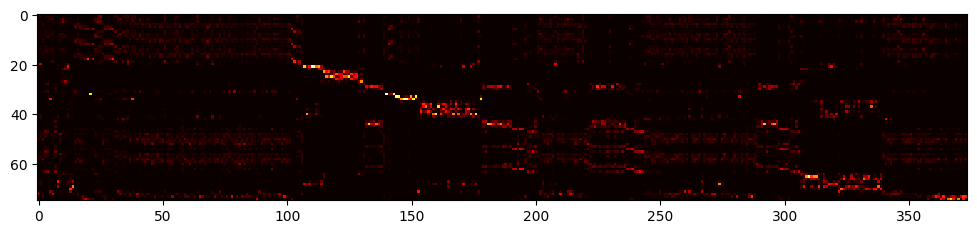

torch.Size([374, 75])


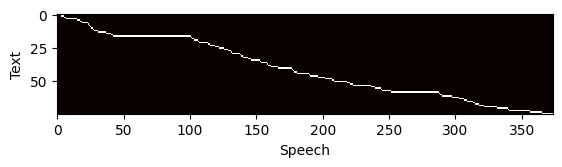

In [31]:
def plot_attention(neg_cent, attn):

    fig, ax = plt.subplots(figsize=(12, 4))

    ax_t = ax.secondary_xaxis('top')

    # plt.colorbar(im,fraction=0.0046)
    # fig.set_figheight(8)
    # fig.set_figwidth(16)
    # x_ticks = [(w["start"] + w["end"]) / 2 for w in words if w["word"] and "actual" not in w["word"]]
    # x_labels = [w["word"] for w in words if w["word"] and "actual" not in w["word"]]
    # ax.set_xticks(x_ticks, x_labels)

    # x_top_ticks = [(w["start"] + w["end"]) / 2 for w in words if w["word"] and "actual" in w["word"]]
    # x_top_labels = ["Ground truth " + w["word"].replace("actual: ", "") + " (green)"  for w in words if w["word"] and "actual" in w["word"]]
    # ax_t.set_xticks(x_top_ticks, x_top_labels)
    # for w in words:
    #     color = "forestgreen" if w["word"] and "actual" in w["word"] else "royalblue"
    #     plt.axvline(x=w["start"], color=color)
    #     plt.axvline(x=w["end"], color=color)
    # neg_cent = neg_cent.squeeze(0)

    # neg_cent = nn.functional.softmax(neg_cent, dim=1)

    # maximum, _ = torch.max(neg_cent, dim=1, keepdim=True)
    # neg_cent = neg_cent * (neg_cent == maximum)

    log_probs = neg_cent
    max_value = torch.max(log_probs) 

    shifted_log_probs = log_probs - max_value

    # Apply the log-sum-exp trick to obtain non-zero probabilities
    probabilities = torch.exp(shifted_log_probs)
    print(f"probability shape is {probabilities.shape}")
    sum_probabilities = torch.sum(probabilities, dim=-1, keepdim=True)
    normalized_probabilities = probabilities / sum_probabilities

    prob_matrix = normalized_probabilities
    prob = prob_matrix.squeeze(0)
    print("prob shape: ", prob.shape)
    prob = prob * (prob == torch.max(prob, dim=1, keepdim=True)[0])

    plt.imshow(prob.transpose(-1, -2), cmap='hot', interpolation='nearest')
    plt.show()
    fig, ax = plt.subplots(figsize=(12, 4))

    im = plt.imshow(neg_cent.transpose(-1, -2), cmap='hot', interpolation='nearest')
    plt.show()
    # plt.yticks([])
    # plt.savefig("neg_cent_repetition.png")
    # plt.show()
    # fig = plt.figure(figsize=(16, 16))
    # ax = plt.gca()
    # im = ax.imshow(prob, cmap='hot', interpolation='nearest')
    # plt.colorbar(im,fraction=0.0046)

    plt.xlabel('Speech')
    plt.ylabel('Text')
    # plt.title(f'{_text}')

    plt.savefig("figure.png")
    # plt.close(fig)
    print(neg_cent.shape)

    plt.imshow(attn.squeeze(0).squeeze(0).transpose(-1, -2), cmap='hot', interpolation='nearest')
    plt.show()

print(x_tst)
plot_attention(neg_cent, attn )


In [32]:
# parse max value from neg_cent 
neg_cent = neg_cent.squeeze(0)
neg_cent = nn.functional.softmax(neg_cent, dim=1)
max_values, indicies = torch.max(neg_cent, dim=1, keepdim=True)
max_values = neg_cent * (neg_cent == max_values)
max_values = max_values.transpose(-1, -2)

print(max_values.shape)


        

torch.Size([75, 374])


In [36]:


stn_tst = get_text("ˈæsk hɜː t..t..t..tə bɹˈɪŋ ðiːz θˈɪŋz wɪð hɜː fɹʌmðə st..st..st..stˈoːɹ", hps)
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])
    sid = torch.LongTensor([51]) # speaker id
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, sid=sid,noise_scale_w=0.8, length_scale=1.6)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

[156, 72, 61, 53, 16, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 16, 50, 87, 158, 16, 62, 4, 4, 62, 4, 4, 62, 4, 4, 62, 83, 16, 44, 123, 156, 102, 112, 16, 81, 51, 158, 68, 16, 119, 156, 102, 112, 68, 16, 65, 102, 81, 16, 50, 87, 158, 16, 48, 123, 138, 55, 81, 83, 16, 61, 62, 4, 4, 61, 62, 4, 4, 61, 62, 4, 4, 61, 62, 156, 57, 158, 123]
tensor([  0, 156,   0,  72,   0,  61,   0,  53,   0,  16,   0,   4,   0,   4,
          0,   4,   0,   4,   0,   4,   0,   4,   0,   4,   0,   4,   0,   4,
          0,   4,   0,   4,   0,   4,   0,   4,   0,   4,   0,   4,   0,   4,
          0,   4,   0,   4,   0,   4,   0,   4,   0,   4,   0,   4,   0,   4,
          0,   4,   0,   4,   0,  16,   0,  50,   0,  87,   0, 158,   0,  16,
          0,  62,   0,   4,   0,   4,   0,  62,   0,   4,   0,   4,   0,  62,
          0,   4,   0,   4,   0,  62,   0,  83,   0,  16,   0,  44,   0, 123,
          0, 156,   0, 102,   0, 112,   0,  16,   0,  81,   0,  51,   0, 158,
      

In [23]:
text = "Ask her to bring these things with her from the store"
phonemes = phonemize(text, language='en-us', backend='espeak', strip=True, preserve_punctuation=True, with_stress=True)
print(phonemes)  # str

ˈæsk hɜː tə bɹˈɪŋ ðiːz θˈɪŋz wɪð hɜː fɹʌmðə stˈoːɹ


### Voice Conversion

In [ ]:
dataset = TextAudioSpeakerLoader(hps.data.validation_files, hps.data)
collate_fn = TextAudioSpeakerCollate()
loader = DataLoader(dataset, num_workers=8, shuffle=False,
    batch_size=1, pin_memory=True,
    drop_last=True, collate_fn=collate_fn)
data_list = list(loader)

In [ ]:
with torch.no_grad():
    x, x_lengths, spec, spec_lengths, y, y_lengths, sid_src = [x.cuda() for x in data_list[0]]
    sid_tgt1 = torch.LongTensor([1]).cuda()
    sid_tgt2 = torch.LongTensor([2]).cuda()
    sid_tgt3 = torch.LongTensor([4]).cuda()
    audio1 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt1)[0][0,0].data.cpu().float().numpy()
    audio2 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt2)[0][0,0].data.cpu().float().numpy()
    audio3 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt3)[0][0,0].data.cpu().float().numpy()
print("Original SID: %d" % sid_src.item())
ipd.display(ipd.Audio(y[0].cpu().numpy(), rate=hps.data.sampling_rate, normalize=False))
print("Converted SID: %d" % sid_tgt1.item())
ipd.display(ipd.Audio(audio1, rate=hps.data.sampling_rate, normalize=False))
print("Converted SID: %d" % sid_tgt2.item())
ipd.display(ipd.Audio(audio2, rate=hps.data.sampling_rate, normalize=False))
print("Converted SID: %d" % sid_tgt3.item())
ipd.display(ipd.Audio(audio3, rate=hps.data.sampling_rate, normalize=False))